# Spam and Ham Classification Project

## Part I: Data Cleaning and Exploration

The first part of the project consist of cleaning up the dataset and exploring interesting aspects about the dataset in order to gain some insights on future feature selections. <br>

In [1]:
# Importing essential packages for analysis

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set(style = "whitegrid", 
        color_codes = True,
        font_scale = 1.5)

### Loading the Dataset 
The goal is to classify emails as spam or not spam using features generated from the text in the email. 

The dataset is from [SpamAssassin](https://spamassassin.apache.org/old/publiccorpus/). It consists of email messages and their labels (0 for ham, 1 for spam). Your labeled training dataset contains 8348 labeled examples, and the unlabeled test set contains 1000 unlabeled examples.

**Note**: The dataset is from 2004, so there might be differences in how spam emails are structured.

#### In the cell below: 
The `train` DataFrame contains labeled data which will be used to train the model. It contains four columns:

1. `id`: An identifier for the training example
1. `subject`: The subject of the email
1. `email`: The text of the email
1. `spam`: 1 if the email is spam, 0 if the email is ham (not spam)

The `test` DataFrame contains 1000 unlabeled emails. This is the dataset for model testing and evaluation.

In [8]:
original_training_data = pd.read_csv('spam_ham_data/train.csv')
test = pd.read_csv('spam_ham_data/test.csv')

# Convert the email contents to lower case before analyzing the text
original_training_data['email'] = original_training_data['email'].str.lower()
test['email'] = test['email'].str.lower()

original_training_data.head()

,id,subject,email,spam
0,0,Subject: A&L Daily to be auctioned in bankrupt...,url: http://boingboing.net/#85534171\n date: n...,0
1,1,"Subject: Wired: ""Stronger ties between ISPs an...",url: http://scriptingnews.userland.com/backiss...,0
2,2,Subject: It's just too small ...,<html>\n <head>\n </head>\n <body>\n <font siz...,1
3,3,Subject: liberal defnitions\n,depends on how much over spending vs. how much...,0
4,4,Subject: RE: [ILUG] Newbie seeks advice - Suse...,hehe sorry but if you hit caps lock twice the ...,0


Checking if our dataset contains missing values and filling in with empty space:

In [9]:
print('Before:')
print(original_training_data.isnull().sum())
original_training_data = original_training_data.fillna('')
print('------------')
print('After:')
print(original_training_data.isnull().sum())

Before:
id         0
subject    6
email      0
spam       0
dtype: int64
------------
After:
id         0
subject    0
email      0
spam       0
dtype: int64


### Data Exploration
1. Check out the structure of the first spam email vs. the first ham email.
2. Create a function to count the whether a series of words appear in certain emails called `words_in_text`.

In [10]:
ham = original_training_data.loc[original_training_data['spam'] == 0, 'email'].iloc[0]
spam = original_training_data.loc[original_training_data['spam'] == 1, 'email'].iloc[0]
print(ham)
print('-----------')
print(spam)

url: http://boingboing.net/#85534171
 date: not supplied
 
 arts and letters daily, a wonderful and dense blog, has folded up its tent due 
 to the bankruptcy of its parent company. a&l daily will be auctioned off by the 
 receivers. link[1] discuss[2] (_thanks, misha!_)
 
 [1] http://www.aldaily.com/
 [2] http://www.quicktopic.com/boing/h/zlfterjnd6jf
 
 

-----------
<html>
 <head>
 </head>
 <body>
 <font size=3d"4"><b> a man endowed with a 7-8" hammer is simply<br>
  better equipped than a man with a 5-6"hammer. <br>
 <br>would you rather have<br>more than enough to get the job done or fall =
 short. it's totally up<br>to you. our methods are guaranteed to increase y=
 our size by 1-3"<br> <a href=3d"http://209.163.187.47/cgi-bin/index.php?10=
 004">come in here and see how</a>
 </body>
 </html>
 
 
 



It can be noted that the first email contains links to external sites which ties together with the content of the email. The second email asks a question without giving any external information like websites. The format of the two emails are also different. One is in html while the other seems like it is in plain text.

### words_in_texts Function
Details: `words_in_texts` takes in a list of `words` and a pandas Series of email `texts`. It outputs a 2-dimensional NumPy array containing one row for each email text. The row contains either a 0 or a 1 for each word in the list: 0 if the word doesn't appear in the text and 1 if the word does. For example: <br>
```
>>> words_in_texts(['hello', 'bye', 'world'], 
                   pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])
```
Explanation: the function returns a list of lists where each element in the outer list is the output of one row in the Pandas series. The first element outputs `[1, 0, 0]` because only the word "hello" appears in the email `'hello'`, thus it only outputs a 1 for the word "hello" and 0s for "bye" and "world". **Note** the function ignores disregards spaces.

In [11]:
def words_in_texts(words, texts):
    '''
    Args:
        words (list): words to find
        texts (Series): strings to search in
    
    Returns:
        NumPy array of 0s and 1s with shape (n, p) where n is the
        number of texts and p is the number of words.
    '''
    # indicator_array = []
    # for text in texts:
    #     word_contain = []
    #     for word in words:
    #         if word in text:
    #             word_contain.append(1)
    #         else:
    #             word_contain.append(0)
    #     indicator_array.append(word_contain)
    indicator_array = np.reshape([int(word in text) for text in texts for word in words], (texts.count(), len(words)))
    return indicator_array

In [12]:
# checking whether the function works
words_in_texts(['hello', 'bye', 'world'], pd.Series(['hello', 'hello worldhello']))

array([[1, 0, 0],
       [1, 0, 1]])

### Training/Validation Split

The training data is all the data for both training models and **validating** the models that we train. Therefore the data should be split into separate training and validation datsets. This **validation data** will be used to assess the performance of the classifier once the training is completed. 

In [14]:
# This creates a 90/10 train-validation split on our labeled data using the scikit-learn package
from sklearn.model_selection import train_test_split
train, val = train_test_split(original_training_data, test_size = 0.1, random_state = 42)

# We must do this in order to preserve the ordering of emails to labels for words_in_texts
train = train.reset_index(drop = True)

## Part II. Feature Engineering and Model Fitting
We now begin to engineer some features to train our model. 

In [15]:
# Building a matrix of 1s and 0s indicating whether an email contains certain words
# These words are a preliminary guess of what might indicate a spam email
some_words = ['drug', 'bank', 'prescription', 'memo', 'private']

X_train = words_in_texts(some_words, train['email'])
Y_train = np.array(train['spam'])

X_train[:5], Y_train[:5]

(array([[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0],
        [0, 0, 0, 1, 0]]),
 array([0, 0, 0, 0, 0]))

In [ ]:
# Testing the model to gain a preliminary understanding of how our model is doing using the LogisticRegression 
# scikit-learn 
from sklearn.linear_model import LogisticRegression

model = LogisticRegression()
model.fit(X_train, Y_train)

training_accuracy = model.score(X_train, Y_train)
print("Training Accuracy: ", training_accuracy)

### Deeper Analysis

After gaining some preliminary understanding, it is time to construct more features to train our model.
Below is a list of features along with respective plots:
- Number of exclamation marks in the head / body
- Number of HTML tags in the body
- Number of websites/external link count
- Proportion of replies in spam or ham emails

In [19]:
# Define Spam and Ham emails
hams = train[train["spam"] == 0]
spams = train[train["spam"] == 1]

Text(0, 0.5, 'Number of !')

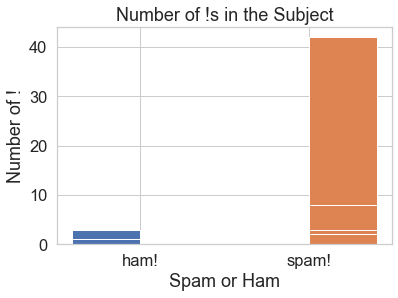

In [20]:
# num of ! in the subject
def num_excl_sub(df):
    return df["subject"].str.findall('!').str.len()
ham_excls = num_excl_sub(hams)
spam_excls = num_excl_sub(spams)
plt.bar(x = 'ham!', align="edge", height = ham_excls, label='ham', width=-0.4)
plt.bar(x = 'spam!', align="edge", height = spam_excls, label='spam', width=0.4)
plt.title("Number of !s in the Subject")
plt.xlabel("Spam or Ham")
plt.ylabel("Number of !")

Text(0, 0.5, 'Number of !')

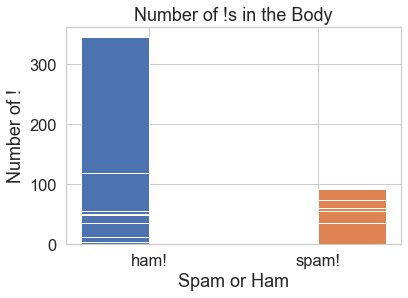

In [21]:
# num of ! in the body 
def num_excl_body(df):
    return df["email"].str.findall('!').str.len()
ham_excls_body = num_excl_body(hams)
spam_excls_body = num_excl_body(spams)
plt.bar(x = 'ham!', align="edge", height = ham_excls_body, label='ham', width=-0.4)
plt.bar(x = 'spam!', align="edge", height = spam_excls_body, label='spam', width=0.4)
plt.title("Number of !s in the Body")
plt.xlabel("Spam or Ham")
plt.ylabel("Number of !")

(5595,)

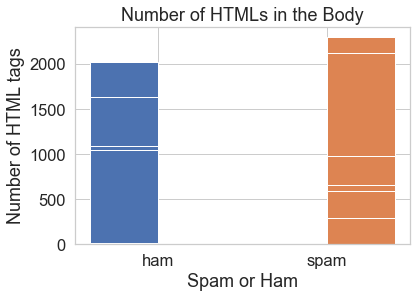

In [22]:
# contains HTML tags count in body
def num_html(df):
    return df["email"].str.findall('<[^>]*>').str.len().fillna(0)

ham_html = num_html(hams)
spam_html = num_html(spams)
plt.bar(x = 'ham', align="edge", height = ham_html, label='ham', width=-0.4)
plt.bar(x = 'spam', align="edge", height = spam_html, label='spam', width=0.4)
plt.title("Number of HTMLs in the Body")
plt.xlabel("Spam or Ham")
plt.ylabel("Number of HTML tags")
ham_html.shape

Text(0, 0.5, 'Number of Links')

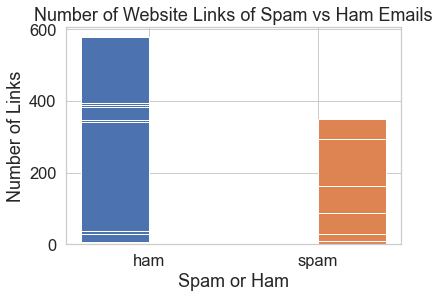

In [23]:
# website/external link count
def num_web_links(df):
    return df["email"].str.count("(.com|.net|.org)")

ham_webs = num_web_links(hams)
spam_webs = num_web_links(spams)
plt.bar(x = 'ham', align="edge", height = ham_webs, label='ham', width=-0.4)
plt.bar(x = 'spam', align="edge", height = spam_webs, label='spam', width=0.4)
plt.title("Number of Website Links of Spam vs Ham Emails")
plt.xlabel("Spam or Ham")
plt.ylabel("Number of Links")

Text(0, 0.5, "Propotion of Re's")

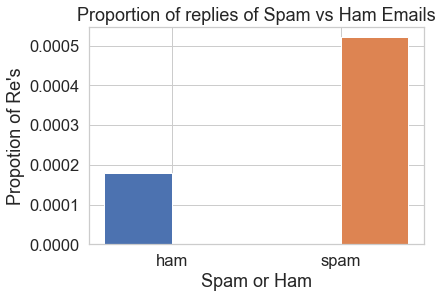

In [24]:
# proportion of replied emails
def replies_prop(df):
    return df["subject"].apply(lambda x: 1 if "Re:" in x else 0)/len(df)

ham_re = replies_prop(hams)
spam_re = replies_prop(spams)

plt.bar(x = 'ham', align="edge", height = ham_re, label='ham', width=-0.4)
plt.bar(x = 'spam', align="edge", height = spam_re, label='spam', width=0.4)
plt.title("Proportion of replies of Spam vs Ham Emails")
plt.xlabel("Spam or Ham")
plt.ylabel("Propotion of Re's")

Below is a function and a plot that gives me a better understanding of what words appear proportionally higher in spam emails. The words with the highest ratio will be used as features to train the final model.

Text(0, 0.5, 'Words')

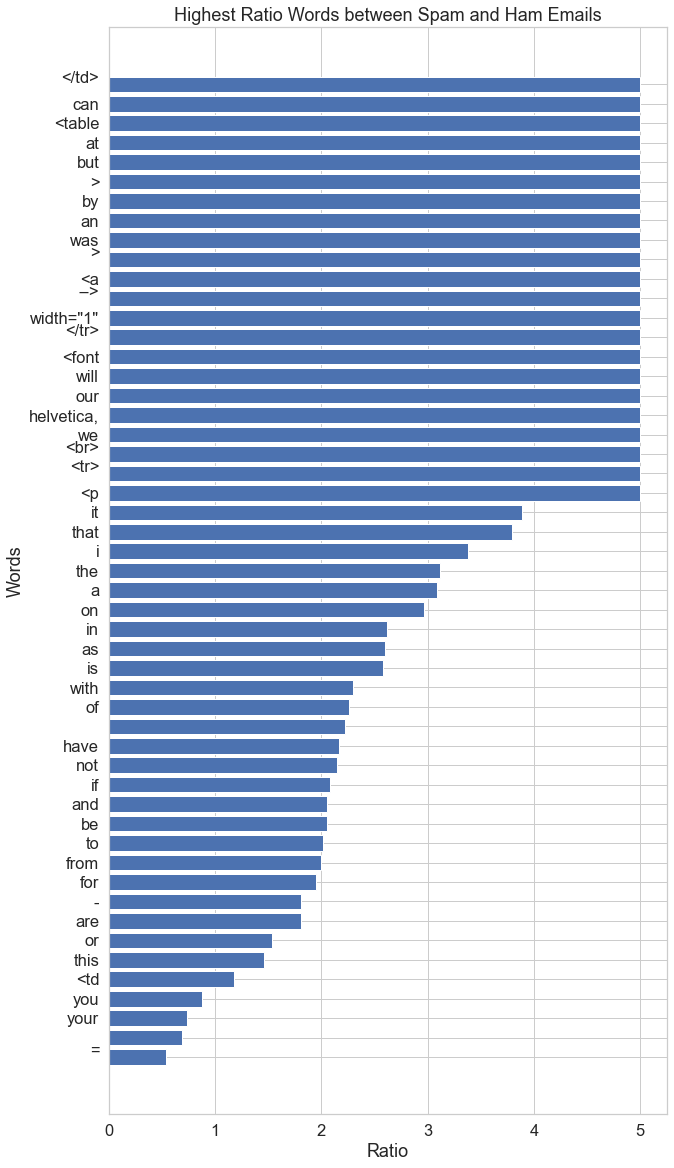

In [25]:
def word_counter(df, spam_or_ham):
    if spam_or_ham == 0:
        email_type = "ham"
    else:
        email_type = "spam"
    words = {}
    email_df = df[df['spam'] == spam_or_ham]['email']
    for body in email_df:
        w = body.split(" ")
        for x in w:
            words[x] = words[x] + 1 if (x in words) else 1
    word_count = pd.DataFrame.from_dict(words, columns = [email_type + '_count'], orient = 'index')
    common_words = word_count.sort_values(by = email_type + '_count', ascending = False)
    common_words['words'] = common_words.index
    common_words = common_words[0:40]
    return common_words

ham_common = word_counter(train, 0)
spam_common = word_counter(train, 1)

spam_and_ham = pd.merge(ham_common, spam_common, how = "outer", on = "words")
spam_and_ham["ratio"] = (spam_and_ham['ham_count'] / spam_and_ham["spam_count"]).replace(np.nan, 5)
spam_and_ham = spam_and_ham.sort_values(by = "ratio", ascending = True)
plt.figure(figsize=(10, 20))
plt.barh(spam_and_ham["words"], spam_and_ham["ratio"], align='center')
plt.title("Highest Ratio Words between Spam and Ham Emails")
plt.xlabel("Ratio")
plt.ylabel("Words")

All the features have been engineered and `data_engineering` puts all the features together and condenses to a single feature matrix that will be fed to the model. The model will be re-validated using the new features.

In [26]:
def data_engineering(df):
    word_list = np.array(spam_and_ham['words'])
    df["subject"] = df["subject"].astype(str)
    replies = df["subject"].apply(lambda x: 1 if ("Re:" in x) else 0)
    matrix_init = np.array(words_in_texts(word_list, df["email"]))
    features = pd.concat([num_excl_sub(df),
                         num_excl_body(df),
                         num_html(df),
                         num_web_links(df),
                         replies], axis=1).values
    matrix_final = np.concatenate((matrix_init, features), axis=1)
    return matrix_final 
X_train = data_engineering(train)
Y_train = train["spam"]
model = LogisticRegression()
model.fit(X_train, Y_train)
model.score(data_engineering(val), val["spam"])

/Users/judyhe/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.9197604790419162

The model trained with new features achieved 91.97% accuracy. 

### The ROC Curve
Logistic regression calculates the probability that a new sample belongs to a certain class. Then, to classify a new sample, the classification is type 1 if it has a $\ge 0.5$ probability of being spam. However, *by adjusting the cutoff*: we can trade off between false positives and false negatives.

The ROC curve visualizes this trade off for each possible cutoff probability. In the cell below plots a ROC curve for the final model.

Text(0, 0.5, 'Sensitivity')

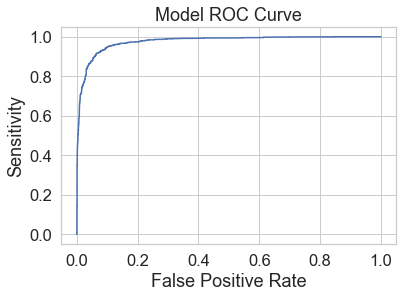

In [27]:
from sklearn.metrics import roc_curve
prob = model.predict_proba(X_train)[:, 1]
fp, sensitivity, threshold = roc_curve(Y_train, prob)
plt.plot(fp, sensitivity)
plt.title("Model ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("Sensitivity")

## Conclusion
This project consist mainly of two parts: cleaning and feature engineering. <br>
The process involves four important aspects that helped improve the accuracy of the final model. They are:
- Feature engineering with text data
- Using sklearn libraries to process data and fit models
- Validating the performance of your model and minimizing overfitting
- Generating and analyzing precision-recall curves

There were several difficulties in the process:
1. Using features that make sense intuitively but ended up being completely unimpactful. Re-experimenting with all different kinds of features is essential in solving this problem. However, it is time-consuming and sometimes disappointing.
2. The dimensions of all the may not match since some emails were excluded if the email doesn't meet criteria. This makes the process of condensing all the features together more complicated then it should. This problem is resolved by checking for dimensions of all the feature matrices before combining all into one big matrix. 